In [1]:
import torch

import triton
import triton.language as tl
import matplotlib
import pandas as pd
import numpy as np


In [2]:
# We can fuse `leaky_relu` by providing it as an `ACTIVATION` meta-parameter in `_matmul`.
@triton.jit
def leaky_relu(x):
    # x = x + 1
    return tl.where(x >= 0, x, 0.01 * x)


In [3]:
# `triton.jit`'ed functions can be auto-tuned by using the `triton.autotune` decorator, which consumes:
#   - A list of `triton.Config` objects that define different configurations of
#       meta-parameters (e.g., `BLOCK_SIZE_M`) and compilation options (e.g., `num_warps`) to try
#   - An auto-tuning *key* whose change in values will trigger evaluation of all the
#       provided configs
@triton.autotune(
    configs=[
        # triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_D': 256, 'BLOCK_SIZE_E': 64, 'BLOCK_SIZE_K': 64}, num_stages=3, num_warps=8),
        # triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_D': 256, 'BLOCK_SIZE_E': 32, 'BLOCK_SIZE_K': 32}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_D': 128, 'BLOCK_SIZE_E': 32, 'BLOCK_SIZE_K': 32}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_D': 64, 'BLOCK_SIZE_E': 32, 'BLOCK_SIZE_K': 32}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_D': 128, 'BLOCK_SIZE_E': 32, 'BLOCK_SIZE_K': 32}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_D': 32, 'BLOCK_SIZE_E': 32, 'BLOCK_SIZE_K': 32}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_D': 32, 'BLOCK_SIZE_E': 32, 'BLOCK_SIZE_K': 32}, num_stages=4, num_warps=2),
        # triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_D': 64, 'BLOCK_SIZE_E': 32, 'BLOCK_SIZE_K': 32}, num_stages=4, num_warps=2),
        triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_E': 32}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 64, 'BLOCK_SIZE_E': 32}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_E': 64}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 64, 'BLOCK_SIZE_E': 64}, num_stages=2, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 128, 'BLOCK_SIZE_E': 64}, num_stages=2, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 64, 'BLOCK_SIZE_E': 128}, num_stages=2, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 128, 'BLOCK_SIZE_E': 128}, num_stages=2, num_warps=4),
    ],
    key=['B', 'D', 'E'],
)
@triton.jit
def mlp_wide_kernel(
    # Pointers to matrices
    x_ptr, w1_ptr, w2_ptr, o_ptr,
    # Matrix dimensions
    H, B, D: tl.constexpr, E,
    # The stride variables represent how much to increase the ptr by when moving by 1
    # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
    # by to get the element one row down (A has M rows).
    stride_xb, stride_xd,
    stride_w1d, stride_w1e,
    stride_w2e, stride_w2d,
    stride_ob, stride_od,
    # Meta-parameters
    BLOCK_SIZE_B: tl.constexpr, BLOCK_SIZE_E: tl.constexpr,
    ACTIVATION: tl.constexpr,
):
    """Kernel for computing the mlp
    Z = X @ W1, H = f(Z), O = H @ W2.
    - X has shape (B, D)
    - W1 has shape (D, E)
    - W2 has shape (E, D)
    - O has shape (B, D)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    pid = tl.program_id(axis=0)
    batch_groups = tl.cdiv(B, BLOCK_SIZE_B)
    pid_b = pid % batch_groups
    pid_h = pid // batch_groups
    # tl.device_print('pid_H', pid_h)
    # tl.device_print('pid_B', pid_b)
    # pid_d = tl.program_id(axis=1)
    TARGET_TYPE = x_ptr.type.element_ty
    x_ptrs = tl.make_block_ptr(
        base=x_ptr,
        shape=(B * H, D),
        strides=(stride_xb, stride_xd),
        offsets=(pid_h * B + pid_b * BLOCK_SIZE_B, 0),
        block_shape=(BLOCK_SIZE_B, D),
        order=(1, 0),
    )
    w1_ptrs = tl.make_block_ptr(
        base=w1_ptr,
        shape=(D * H, E),
        strides=(stride_w1d, stride_w1e),
        offsets=(pid_h * D, 0),
        block_shape=(D, BLOCK_SIZE_E),
        order=(1, 0),
    )
    w2_ptrs = tl.make_block_ptr(
        base=w2_ptr,
        shape=(E * H, D),
        strides=(stride_w2e, stride_w2d),
        offsets=(pid_h * E, 0),
        block_shape=(BLOCK_SIZE_E, D),
        order=(1, 0),
    )
    o_ptrs = tl.make_block_ptr(
        base=o_ptr,
        shape=(B * H, D),
        strides=(stride_ob, stride_od),
        offsets=(pid_h * B + pid_b * BLOCK_SIZE_B, 0),
        block_shape=(BLOCK_SIZE_B, D),
        order=(1, 0),
    )
    x = tl.load(x_ptrs) # BLOCK_SIZE_B, D
    o = tl.zeros((BLOCK_SIZE_B, D), dtype=tl.float32)
    for e in range(0, tl.cdiv(E, BLOCK_SIZE_E)):
        # z = tl.zeros((BLOCK_SIZE_B, BLOCK_SIZE_E), dtype=tl.float32)
        # loop over D
        w1 = tl.load(w1_ptrs)       # D, BLOCK_SIZE_E
        w2 = tl.load(w2_ptrs)       # BLOCK_SIZE_E, D
        z = tl.dot(x, w1, out_dtype=tl.float32)        # BLOCK_SIZE_B, BLOCK_SIZE_E
        # activation
        if ACTIVATION == "leaky_relu":
            z = leaky_relu(z).to(TARGET_TYPE)
        else:
            z = z.to(TARGET_TYPE)
        # accumulate with o
        o = tl.dot(z, w2, o, out_dtype=tl.float32)        # BLOCK_SIZE_B, D
        # advance w1 and w2
        w1_ptrs = tl.advance(w1_ptrs, (0, BLOCK_SIZE_E))
        w2_ptrs = tl.advance(w2_ptrs, (BLOCK_SIZE_E, 0))
    o = o.to(TARGET_TYPE)
    # store o
    # tl.static_print('o_ptrs', o_ptrs, o)
    tl.store(o_ptrs, o)


In [4]:
def mlp_wide_triton(x, w1, w2, activation=""):
    # Check constraints.
    assert x.shape[0] == w1.shape[0], "Incompatible dimensions"
    assert x.shape[0] == w2.shape[0], "Incompatible dimensions"
    assert x.shape[2] == w1.shape[1], "Incompatible dimensions"
    assert w1.shape[2] == w2.shape[1], "Incompatible dimensions"
    assert x.shape[2] == w2.shape[2], "Incompatible dimensions"

    H, B, D = x.shape
    E = w1.shape[-1]

    # print(H, B, D, E)
    # print(x.shape, w1.shape, w2.shape)

    x = x.view(H * B, D)
    w1 = w1.view(D * H, E)
    w2 = w2.view(E * H, D)

    assert x.is_contiguous(), "Matrix X must be contiguous"
    assert w1.is_contiguous(), "Matrix W1 must be contiguous"
    assert w2.is_contiguous(), "Matrix W2 must be contiguous"

    # Allocates output.
    o = torch.empty_like(x)
    #print(x.shape, w1.shape, w2.shape, o.shape)
    # print(o.shape)

    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (
        triton.cdiv(B, META['BLOCK_SIZE_B']) * H,
    )
    mlp_wide_kernel[grid](
        x, w1, w2, o,
        H, B, D, E,
        x.stride(0), x.stride(1),
        w1.stride(0), w1.stride(1),
        w2.stride(0), w2.stride(1),
        o.stride(0), o.stride(1),
        ACTIVATION=activation
    )

    # print(o.shape)
    return o.reshape(H, B, D)


In [5]:
def mlp_torch(x, w1, w2, activation=""):
    z = torch.bmm(x, w1)
    if activation == "leaky_relu":
        z = torch.nn.functional.leaky_relu(z)
    o = torch.bmm(z, w2)
    return o


In [9]:
def unit_test_simple():
    # torch.manual_seed(115)
    dtype = torch.bfloat16
    B = 1024
    D = 16
    E = 64
    H = 12
    x = torch.randn((H, B, D), device='cuda', dtype=dtype)
    w1 = torch.randn((H, D, E), device='cuda', dtype=dtype)
    w2 = torch.randn((H, E, D), device='cuda', dtype=dtype)
    triton_output = mlp_wide_triton(x, w1, w2, activation="leaky_relu")
    torch_output = mlp_torch(x, w1, w2, activation="leaky_relu")
    print(f"triton_output={triton_output.shape, triton_output}")
    print(f"torch_output={torch_output.shape, torch_output}")
    if torch.allclose(triton_output, torch_output, atol=1e-2, rtol=1e-2):
        print("✅ Triton and Torch match")
    else:
        print("❌ Triton and Torch differ")

    diff = np.abs(triton_output.to(torch.float32).cpu().numpy() - torch_output.to(torch.float32).cpu().numpy())
    print("max diff:",np.max(diff))
    print("mean diff:",np.mean(diff))

unit_test_simple()


triton_output=(torch.Size([12, 1024, 16]), tensor([[[ 25.7500,  15.2500, -49.0000,  ...,   5.8750, -10.2500,  -1.7734],
         [ 13.0625, -11.6250,  12.1250,  ...,   4.9062, -13.3125,  14.6250],
         [ 58.0000,  23.3750,  10.0000,  ...,  11.1875,  14.3750,  11.8125],
         ...,
         [ 14.8750,  55.7500,  -1.0938,  ..., -10.2500,  20.3750,   0.7305],
         [-11.6875, -14.2500,   2.1719,  ...,  13.3750,   3.0625,   1.4062],
         [  7.9062,  27.6250,  23.3750,  ..., -14.1875,  25.2500,   6.9375]],

        [[  4.2812,  13.0000,  13.6875,  ..., -30.1250, -23.7500,   6.9688],
         [-18.1250, -18.6250,  11.9375,  ...,   4.2812,   1.7031, -16.7500],
         [  2.2969,  -9.6875,  -6.0625,  ...,  24.2500, -24.3750, -10.7500],
         ...,
         [-48.2500,   1.5781, -10.6875,  ...,  11.1250, -24.3750, -17.2500],
         [-35.0000, -26.6250,  -3.2969,  ...,   2.3438, -27.6250, -49.2500],
         [ 28.1250,  14.7500,  32.0000,  ..., -11.0625,  -2.1875,  -1.3047]],

 

In [7]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['E'],  # Argument names to use as an x-axis for the plot
        x_vals=[
            # 2 ** i for i in range(5, 12)
            128 * i for i in range(2, 16)
        ],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['torch-32', 'triton-32', 'torch-64', 'triton-64', 'torch-128', 'triton-128'],
        # Label name for the lines
        line_names=["Torch-32", "Triton-32", "Torch-64", "Triton-64", "Torch-128", "Triton-128"],
        # Line styles
        styles=[('green', ':'), ('blue', ':'), ('green', '--'), ('blue', '--'), ('green', '-'), ('blue', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="mlp-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    )
)
def benchmark(E, provider):
    dtype = torch.bfloat16
    D = int(provider[provider.find('-') + 1:])
    HEAD = 768 // D
    B = 1024
    x = torch.randn((HEAD, B, D), device='cuda', dtype=dtype)
    w1 = torch.randn((HEAD, D, E), device='cuda', dtype=dtype)
    w2 = torch.randn((HEAD, E, D), device='cuda', dtype=dtype)
    quantiles = [0.5, 0.2, 0.8]
    if provider.startswith('torch'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mlp_torch(x, w1, w2, activation="leaky_relu"), quantiles=quantiles)
    if provider.startswith('triton'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mlp_wide_triton(x, w1, w2, activation="leaky_relu"), quantiles=quantiles)
    perf = lambda ms: 4 * B * D * E * HEAD * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


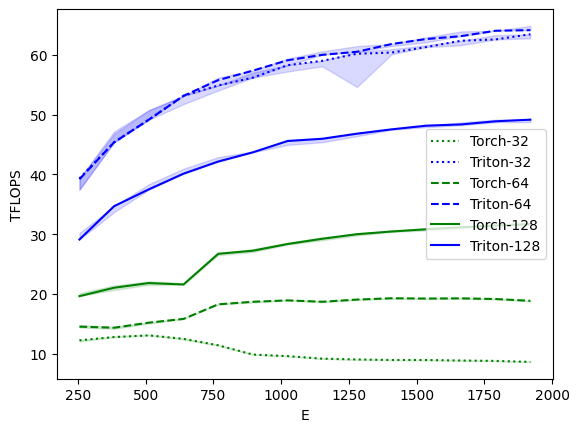

mlp-performance:
         E   Torch-32  Triton-32   Torch-64  Triton-64  Torch-128  Triton-128
0    256.0  12.288000  39.321601  14.563556  39.199103  19.660800   29.127111
1    384.0  12.822261  45.371077  14.385951  45.371077  21.065143   34.695529
2    512.0  13.107200  49.152000  15.233550  49.152000  21.845333   37.504955
3    640.0  12.522802  53.137295  15.855484  53.137295  21.605274   40.124083
4    768.0  11.452893  54.867349  18.289117  55.758844  26.738967   42.153809
5    896.0   9.901679  56.173716  18.724572  57.343998  27.252595   43.690667
6   1024.0   9.640231  58.254222  18.950169  59.074702  28.371842   45.590260
7   1152.0   9.216000  58.982401  18.724572  59.982100  29.247472   45.960314
8   1280.0   9.081201  60.162143  19.088156  60.494769  30.016490   46.811429
9   1408.0   8.992466  60.362857  19.309714  61.791084  30.460393   47.531604
10  1536.0   8.987795  61.280418  19.259559  62.627518  30.840470   48.148900
11  1664.0   8.905589  62.339123  19.289841  63

In [8]:
benchmark.run(show_plots=True, print_data=True)
